In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
from branca.element import Template, MacroElement
from folium.plugins import MarkerCluster
import os
import time
import datetime

In [2]:
import pyroutelib3
from pyroutelib3 import Router
import requests, json
import urllib.parse
import tempfile
import zipfile

In [3]:
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# I) Utilisation du GPS 

## Choix du point de départ et du point d'arrivée

In [5]:
adresse_depart =input("D'où partez-vous ? (numéro, rue, code postal ville)")

adresse_arrivee = input("Où voulez-vous aller ? (numéro, rue, code postal ville)")

D'où partez-vous ? (numéro, rue, code postal ville)5, Avenue Anatole France, 75007 Paris
Où voulez-vous aller ? (numéro, rue, code postal ville)1, Rue de Rivoli, 75001 Paris


In [6]:
#print(adresse_depart)

In [7]:
#print(adresse_arrivee)

In [8]:
#adresse_depart = "5, Avenue Anatole France, 75007 Paris"
#adresse_arrivee = "1, Rue de Rivoli, 75001 Paris"
dep_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_depart) + "&format=json").json()
arr_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_arrivee) + "&format=json").json()
coord_dep = list(dep_json['features'][0].get('geometry').get('coordinates'))
coord_arr = list(arr_json['features'][0].get('geometry').get('coordinates'))

In [9]:
x = input("Avez-vous votre propre vélo ? Entrez 'oui' ou 'non' ")

Avez-vous votre propre vélo ? Entrez 'oui' ou 'non' oui


## Lorsque l'utilisateur n'a pas son propre vélo

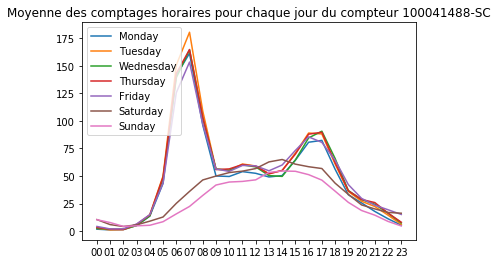

In [10]:
%run './compteurs.ipynb'

In [11]:
def trajet_velo(coor_depart, coor_arrivee, idf):
    
    router = pyroutelib3.Router("cycle")
    depart = router.findNode(coor_depart[0], coor_depart[1])
    #print(depart)
    arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])
    #print(arrivee)

    routeLatLons=[coor_depart,coor_arrivee]
    
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("Votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    folium.PolyLine(routeLatLons, color="blue", weight=2.5, opacity=1).add_to(idf)
    
    return routeLatLons
    
    
    
def trajet_pied(coor_depart, coor_arrivee, idf):
    
    router = pyroutelib3.Router("foot")
    depart = router.findNode(coor_depart[0], coor_depart[1])
    #print(depart)
    arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])

    routeLatLons=[coor_depart,coor_arrivee]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    folium.PolyLine(routeLatLons, color="black", weight=2.5, opacity=1).add_to(idf)
    
    return routeLatLons

def print_centroids(routeLatLons):
    # Affichage des lieux accidentogènes situés à moins de 50 mètres du trajet 
    centroids = pd.read_csv("centroids_df.csv")

    dist_centroids = []
    centroids_50 = []

    for i in range( centroids.shape[0]) : 
        for k in routeLatLons : 
            dist = (k[0]- centroids["lat"][i] )**2 + (k[1]- centroids["lon"][i] )**2
            dist = dist**1/2*100
            if dist < 0.0005 :
                dist_centroids.append(dist)
                centroids_50.append([centroids["lat"][i], centroids["lon"][i]])

    for i in range(len(centroids_50)) : 
        coord = centroids_50[i]
        folium.Circle(coord,radius=60, popup='Lieu accidentogene',color='crimson',fill=True,).add_to(idf)
    

In [12]:
if(x=='non'):
                                                                                 
    coor_depart = [coord_dep[1], coord_dep[0]] 
    coor_arrivee = [coord_arr[1], coord_arr[0]] 
    
    # Ré-initialisation de la carte 
    centre = coor_depart 
    idf = folium.Map(location = centre, zoom_start = 13)
    
    folium.Marker(coor_depart,popup="Depart", icon=folium.Icon(color='blue',icon='location-arrow', prefix='fa') ).add_to(idf)
    folium.Marker(coor_arrivee, popup='Depart', icon=folium.Icon(color='blue',icon='map-pin', prefix='fa')).add_to(idf)
    
    # Calcul de la distance en km entre le point de départ et toutes les stations

    distances = []
    for i in range(len(velos.geometry)):
      a = (max(velos.geometry[i].x, coord_dep[0]) - min(velos.geometry[i].x, coord_dep[0]))**2 + (max(velos.geometry[i].y, coord_dep[1]) - min(velos.geometry[i].y, coord_dep[1]))**2
      a = a**(1/2)*100
      distances.append(a)
    
    #Station la plus proche du point de départ 

    i = distances.index(min(distances))
    station_dep = [velos["geometry"][i].y, velos["geometry"][i].x]
    print( 'Station la plus proche du point de départ :', velos["name"][i] )
    
    # Vérification disponibilité vélo dans la station de départ
    
    if(velos["numbikesavailable"][i]!="0" and velos["numbikesavailable"][i]!="N" ):
        print("\n \n Un vélo est disponible à la station la plus proche du point de départ")
        
    elif(velos["numbikesavailable"][i]=="N"):
        print("\n \n Nous ne disposons pas d'information concernant la disponibilité d'un vélo à la station la plus proche du point de départ")
        
    elif(velos["numbikesavailable"][i]=="0"):
        print("\n \n Pas de vélo disponible à la station la plus proche du point de départ")
        
        while( velos["numbikesavailable"][i]=="0"):
            # Nouvelle station la plus proche et avec vélo disponible
            distances.pop(i)
            i = distances.index(min(distances))
            station_dep = [velos["geometry"][i].y, velos["geometry"][i].x]

        print( 'Station la plus proche du point de départ avec vélo disponible : \n', velos["name"][k] )  
    
    print('\n \nDistance à effectuer à pied (point de départ -> station de départ) :', round(min(distances),2), "km")
    print("soit un temps de trajet d'environ :", round(min(distances)*1000/66.67), "minutes\n \n")
    
    t = min(distances)*1000/66.67
        
    
    # Calcul de la distance en km entre le point d'arrivée et toutes les stations

    distances = []
    for i in range(len(velos.geometry)):
      a = (max(velos.geometry[i].x, coord_arr[0]) - min(velos.geometry[i].x, coord_arr[0]))**2 + (max(velos.geometry[i].y, coord_arr[1]) - min(velos.geometry[i].y, coord_arr[1]))**2
      a = a**(1/2)*100
      distances.append(a)
    
    #Station la plus proche du point d'arrivée

    j = distances.index(min(distances))

    station_arr = [velos["geometry"][j].y, velos["geometry"][j].x] 
    
    print( 'Station la plus proche du point d arrivée : ', velos["name"][j] )
    
    # Vérification disponibilité dock dans la station d'arrivée
    
    if(velos["numdocksavailable"][j]!="0" and velos["numdocksavailable"][j]!="N" ):
        print("\n Un dock est disponible à la station la plus proche du point d'arrivée")
    
    elif(velos["numdocksavailable"][j]=="N"):
        print("\nNous ne disposons pas d'information concernant la disponibilité d'un dock à la station la plus proche du point d'arrivée")
    
    elif(velos["numdocksavailable"][j]=="0"):
        print("\nPas de dock disponible à la station la plus proche du point d'arrivée'")
        
        while( velos["numdocksavailable"][j]=="0"):
            # Nouvelle station la plus proche et avec dock disponible
            distances.pop(j)
            j = distances.index(min(distances))
            station_arr = [velos["geometry"][j].y, velos["geometry"][j].x]

        print( "Station la plus proche du point d'arrivée avec dock disponible : \n", velos["name"][k] )
        
    # Durée et distance trajet à vélo
    
    d = (max(station_dep[0], station_arr[0]) - min(station_dep[0], station_arr[0]))**2 + (max(station_dep[1], station_arr[1]) - min(station_dep[1], station_arr[1]))**2
    d = d**(1/2)*100                                                                                                 

    print( '\n \nDistance à effectuer en vélo (station de départ -> station d\'arrivée) :', round(d,2), "km")
    print("soit un temps de trajet d'environ :", round(d*1000/250), "minutes\n")
    print( '\n Distance à effectuer à pied (station d\'arrivée -> point d\'arrivée) :', round(min(distances),2), "km")
    print("soit un temps de trajet d'environ :", round(min(distances)*1000/66.67), "minutes\n \n")
    
    print("Le temps total du trajet est donc de :", round(t+d*1000/250+min(distances)*1000/66.67)  ,"minutes\n \n")
    
    # Si le temps total du trajet calculé > temps de trajet en faisant tout à pied, alors faire le trajet à pied 
    
    d_pied = (max(coord_dep[0], coord_arr[0]) - min(coord_dep[0], coord_arr[0]))**2 + (max(coord_dep[1], coord_arr[1]) - min(coord_dep[1], coord_arr[1]))**2
    d_pied = d_pied**(1/2)*100
    t_pied = d_pied*1000/66.67
    
    if( t+d*1000/250+min(distances)*1000/66.67 > t_pied ):
        
        print("ATTENTION : Il serait plus judicieux de faire tout le trajet à pied car :")
        print("Distance du point de départ au point d'arrivée :", round(d_pied,2), "km")
        print("Temps du trajet à pied :", round(t_pied), "minutes\n" )
            
    #Trajet à pied : point de départ -> station départ
    
    routeLatLons = trajet_pied(coor_depart, station_dep, idf)
    print_centroids(routeLatLons)
    
    # Trajet en vélo : station départ -> station arrivée
    
    routeLatLons = trajet_velo(station_dep, station_arr, idf)
    print_centroids(routeLatLons)
        
    # Trajet à pied : station arrivée -> point d'arrivée
    
    routeLatLons = trajet_pied(station_arr, coor_arrivee, idf)
    print_centroids(routeLatLons)
        
    # Affichage des compteurs 
    
    length = []
    tokeep = []
    for i in final.index : 
        for k in routeLatLons : 
            dist = (k[0]-float(final['long'][i]))**2 + (k[1]-float(final['lat'][i]))**2
            dist = dist**1/2*100
            if dist < 0.0005:
                length.append(dist)
                tokeep.append(i)

    tokeep = list(set(tokeep)) #on ne garde qu'une fois chaque nom de compteur
    
    #Fonction qui place un marqueur pour chaque compteur de la couleur de l'indice de congestion associé
    
    def circle (data):
        for i in tokeep: #pour afficher tous les compteurs : remplacer tokeep par data.index
            coord = []
            lat = float(data.loc[i]['lat'])
            long = float(data.loc[i]['long'])
            coord.append(long)
            coord.append(lat)
            folium.Circle(coord,radius = 200,fill=True, color = data.loc[i]['congestion'], fill_color=data.loc[i]['congestion'], popup = data.loc[i]['nom_compteur']).add_to(idf)

    circle(final)
    
    # Légendes 

    template = """
    {% macro html(this, kwargs) %}

    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <title>jQuery UI Draggable - Default functionality</title>
      <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

      <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
      <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>

      <script>
      $( function() {
        $( "#maplegend" ).draggable({
                        start: function (event, ui) {
                            $(this).css({
                                right: "auto",
                                top: "auto",
                                bottom: "auto"
                            });
                        }
                    });
    });

      </script>
    </head>
    <body>


    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 1);
         border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>


    <div class='legend-title'>Indice de congestion des pistes</div>
    <div class='legend-scale1'>
      <ul class='legend-labels1'>
        <li><span style='background:green;opacity:0.6;'></span>Fluide</li>
        <li><span style='background:orange;opacity:0.6;'></span>Passant</li>
        <li><span style='background:red;opacity:0.6;'></span>Congestion</li>

    <div class='legend-title'>Accidents</div>
    <div class='legend-scale2'>
      <ul class='legend-labels2'>
        <li><span style='background:red;opacity:1;'></span>Centre d'un cluster d'accidents</li> 

    <div class='legend-title'>Itineraire</div>
    <div class='legend-scale3'>
      <ul class='legend-labels3'>
        <li><span style='background:black;opacity:1;'></span>Trajet a pieds</li>
        <li><span style='background:blue;opacity:1;'></span>Trajet a velo</li>


      </ul>
    </div>
    </div>

    </body>
    </html>

    <style type='text/css'>
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale1 ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale1 ul li {
        font-size: 90%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels1 li span {
        display: block;
        float: left;
        height: 16px;
        width: 16px;
        border-radius: 8px;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }


    <style type='text/css'>
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale2 ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale2 ul li {
        font-size: 90%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels2 li span {
        display: block;
        float: left;
        height: 8px;
        width: 8px;
        border-radius: 4px;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }

    <style type='text/css'>
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale3 ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale3 ul li {
        font-size: 90%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels3 li span {
        display: block;
        float: left;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        display: inline-block;
        width: 50px;
        }   

      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        } 


    </style>
    {% endmacro %}"""

    macro = MacroElement()
    macro._template = Template(template)

    idf.get_root().add_child(macro)

    

In [13]:
idf

# Lorsque l'utilisateur a son propre vélo

In [20]:
if(x=='oui'):
    
    coor_depart = [coord_dep[1], coord_dep[0]] 
    coor_arrivee = [coord_arr[1], coord_arr[0]] 
    
    # Ré-initialisation de la carte 
    centre = coor_depart 
    idf = folium.Map(location = centre, zoom_start = 13)

    folium.Marker(coor_depart,popup="Depart", icon=folium.Icon(color='blue',icon='location-arrow', prefix='fa') ).add_to(idf)
    folium.Marker(coor_arrivee, popup='Depart', icon=folium.Icon(color='blue',icon='map-pin', prefix='fa')).add_to(idf)
    
    # Trajet en vélo : point départ -> point d'arrivée
    
    routeLatLons = trajet_velo(coor_depart, coor_arrivee, idf)
    print_centroids(routeLatLons)
    
    # Affichage des compteurs 
    
    length = []
    tokeep = []
    for i in final.index : 
        for k in routeLatLons : 
            dist = (k[0]-float(final['long'][i]))**2 + (k[1]-float(final['lat'][i]))**2
            dist = dist**1/2*100
            if dist < 0.0005:
                length.append(dist)
                tokeep.append(i)

    tokeep = list(set(tokeep)) #on ne garde qu'une fois chaque nom de compteur
    
    #Fonction qui place un marqueur pour chaque compteur de la couleur de l'indice de congestion associé
    def circle (data):
        for i in tokeep: #pour afficher tous les compteurs : remplacer tokeep par data.index
            coord = []
            lat = float(data.loc[i]['lat'])
            long = float(data.loc[i]['long'])
            coord.append(long)
            coord.append(lat)
            folium.Circle(coord,radius = 100,fill=True, color = data.loc[i]['congestion'], fill_color=data.loc[i]['congestion'], popup = data.loc[i]['nom_compteur']).add_to(idf)

    circle(final)
        
    # Légendes

    template = """
    {% macro html(this, kwargs) %}

    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <title>jQuery UI Draggable - Default functionality</title>
      <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

      <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
      <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>

      <script>
      $( function() {
        $( "#maplegend" ).draggable({
                        start: function (event, ui) {
                            $(this).css({
                                right: "auto",
                                top: "auto",
                                bottom: "auto"
                            });
                        }
                    });
    });

      </script>
    </head>
    <body>


    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 1);
         border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>


    <div class='legend-title'>Indice de congestion des pistes</div>
    <div class='legend-scale1'>
      <ul class='legend-labels1'>
        <li><span style='background:green;opacity:0.6;'></span>Fluide</li>
        <li><span style='background:orange;opacity:0.6;'></span>Passant</li>
        <li><span style='background:red;opacity:0.6;'></span>Congestion</li>

    <div class='legend-title'>Accidents</div>
    <div class='legend-scale2'>
      <ul class='legend-labels2'>
        <li><span style='background:red;opacity:1;'></span>Centre d'un cluster d'accidents</li> 

    <div class='legend-title'>Itineraire</div>
    <div class='legend-scale3'>
      <ul class='legend-labels3'>
        <li><span style='background:blue;opacity:1;'></span>Trajet a velo</li>


      </ul>
    </div>
    </div>

    </body>
    </html>

    <style type='text/css'>
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale1 ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale1 ul li {
        font-size: 90%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels1 li span {
        display: block;
        float: left;
        height: 16px;
        width: 16px;
        border-radius: 8px;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }


    <style type='text/css'>
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale2 ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale2 ul li {
        font-size: 90%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels2 li span {
        display: block;
        float: left;
        height: 8px;
        width: 8px;
        border-radius: 4px;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }

    <style type='text/css'>
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale3 ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale3 ul li {
        font-size: 90%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels3 li span {
        display: block;
        float: left;
        margin-right: 5px;
        margin-left: 0;
        border: 1px solid #999;
        display: inline-block;
        width: 50px;
        }   

      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        } 


    </style>
    {% endmacro %}"""

    macro = MacroElement()
    macro._template = Template(template)

    idf.get_root().add_child(macro)


In [21]:
idf